In [115]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import TransformerMixin, BaseEstimator

In [116]:
body_perform = pd.read_csv("C:\\Users\\User\\Desktop\\ML_final\\bodyPerformance.csv")

In [117]:
columns = ["age","height_cm", "weight_kg", "body fat_%", "diastolic", "systolic", "gripForce", "sit and bend forward_cm", "sit-ups counts", "broad jump_cm"]
body_perform["class"] = body_perform["class"].map({"A":3,"B":2,"C":1,"D":0})
body_perform["gender"] = body_perform["gender"].map({"M":0,"F":1})

In [118]:
body_perform.head(10)
preprocess_column = ["height_cm", "weight_kg", "body fat_%", "diastolic", "systolic", "gripForce", "sit and bend forward_cm", "sit-ups counts", "broad jump_cm"]
rank_column = ["gripForce", "sit and bend forward_cm", "sit-ups counts", "broad jump_cm"]

In [119]:
# second
class impute_data(TransformerMixin):
    def __init__(self,cols=None,strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    def fit(self,*_):
        return self
    def transform(self,df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
# first
class unqualify_None(TransformerMixin):
    def __init__(self,cols=None):
        self.col = cols
    def fit(self,*_):
        return self
    def transform(self,df):
        X = df.copy()
        for cols in self.col:
            # replace 0
            X[cols].replace([0],[None],inplace=True)
            # replace value < 0
            if cols == "diastolic":
                X[cols] = X[cols].map(lambda x: None if x is not None and x<=40 else x)
            elif cols == "systolic":
                X[cols] = X[cols].map(lambda x: None if x is not None and x<=70 else x)
            elif cols == "sit and bend forward_cm":
                X[cols] = X[cols].map(lambda x: None if x is not None and (x<=0 or x>=100) else x)
            else:
                X[cols] = X[cols].map(lambda x: None if x is not None and x<=0 else x)
            
        

        return X
# third
class perform_range(TransformerMixin):
    def __init__(self,cols,bins,labels=False):
        self.labels = labels
        self.bins = bins
        self.col = cols
    def fit(self,*_):
        return self
    def transform(self,df):
        X = df.copy()
        for col in self.col:
            X[col] = pd.cut(X[col],bins=self.bins,labels=self.labels)
        return X
# fourth
class select_my_feature(TransformerMixin,BaseEstimator):
    def __init__(self,response,cols_to_keep=[],threshold=None):
        self.response = response
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep
    def fit(self,X,*_):
        df = pd.concat([X,self.response],axis=1)
        self.cols_to_keep = df.columns[df.corr()[df.columns[-1]].abs() > self.threshold]
        self.cols_to_keep = [c for c in self.cols_to_keep if c in X.columns]
        return self
    def transform(self,X):
        return X[self.cols_to_keep]
# five add data
class addleanBMI(TransformerMixin):
    def __init__(self,fat='body fat_%',height="height_cm",weight="weight_kg"):
        self.fat = fat
        self.height = height
        self.weight = weight
    def fit(self,*_):
        return self
    def transform(self,df):
        X = df.copy()
        body_fat = X['body fat_%'] / 100
        height_m = X['height_cm'] / 100
        lean_mass = X['weight_kg'] * (1-body_fat)

        X['lean_BMI'] = lean_mass / height_m**2
        return X




In [120]:
ID = impute_data(cols=preprocess_column)
UN = unqualify_None(cols=preprocess_column)
PR = perform_range(cols=rank_column,bins=5)
ALB = addleanBMI()
## need adjust according to your pipeline
# pipe = Pipeline([("remover",UN),("imputer",ID),("addBMI",ALB)])
pipe = Pipeline([("remover",UN),("imputer",ID)])
# pipe = Pipeline([("remover",UN),("imputer",ID),("rank",PR)])
final_data = pipe.fit_transform(body_perform)


C:\Users\User\AppData\Local\Temp\ipykernel_7028\690853079.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[cols].replace([0],[None],inplace=True)


In [121]:
final_data

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.000000,217.0,1
1,25.0,0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.000000,229.0,3
2,31.0,0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.000000,181.0,1
3,32.0,0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.000000,219.0,2
4,28.0,0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.000000,217.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.000000,198.0,1
13389,21.0,0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.000000,167.0,0
13390,39.0,0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.000000,229.0,3
13391,64.0,1,146.1,57.70,40.4,68.0,121.0,19.3,9.2,40.145915,75.0,0


In [122]:
final_data.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,0.367804,168.559807,67.447316,23.240165,78.823119,130.259671,36.972159,16.280739,40.145915,190.271695,1.499813
std,13.625639,0.482226,8.426583,11.949666,7.256844,10.664723,14.617382,10.610447,6.462138,13.744856,39.527763,1.118109
min,21.000000,0.000000,125.000000,26.300000,3.000000,41.000000,77.000000,1.600000,0.100000,1.000000,20.000000,0.000000
25%,25.000000,0.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,12.200000,31.000000,162.000000,0.000000
50%,32.000000,0.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.280739,41.000000,193.000000,1.000000
75%,48.000000,1.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,2.000000
max,64.000000,1.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,42.000000,80.000000,303.000000,3.000000


<Axes: >

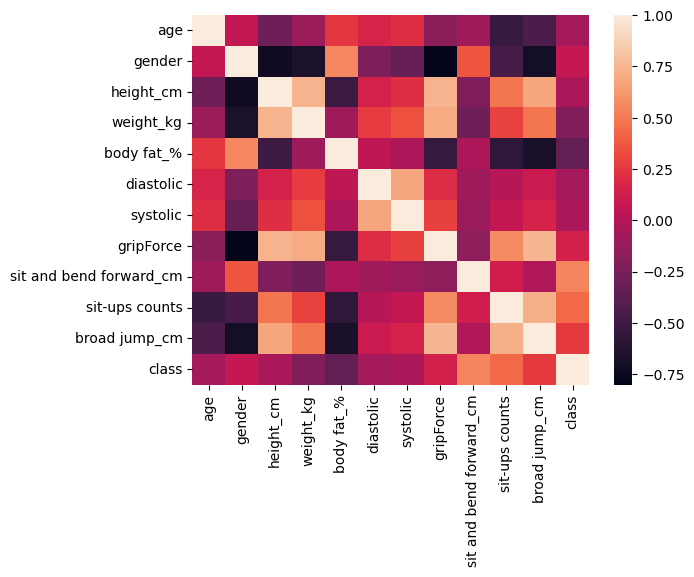

In [123]:
sb.heatmap(final_data.corr())

In [124]:
# final_data.corr()['lean_BMI']

In [125]:
final_data.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X = final_data.drop('class', axis = 1)
y = final_data['class']
SL = select_my_feature(response=y)
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0)
    grid.fit(X, y)
    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))

In [106]:
lr = LogisticRegression()
lr_params = {'scalar':[StandardScaler(), MinMaxScaler()],
            'classifier__C':[1e-1, 1e0, 1e1, 1e2],
            'classifier__penalty':['l1', 'l2'],
            'classifier__solver': ['liblinear'],
            'select_my_feature__threshold':[0,.1,.2,.3]}
lr_pipe = Pipeline([('select_my_feature',SL),('scalar',StandardScaler),('classifier',lr)])
# lr_pipe = Pipeline([('scalar',StandardScaler),('classifier',lr)])
get_best_model_and_accuracy(lr_pipe, lr_params, X, y) 

c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\svm\_base.py:1237: Conv

Best Accuracy: 0.5741060180682268
Best Parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'scalar': StandardScaler(), 'select_my_feature__threshold': 0}
Average Time to Fit (s): 0.957
Average Time to Score (s): 0.003


In [107]:

knn = KNeighborsClassifier()
knn_pipe_params = {'classify__n_neighbors': [1, 3, 5, 7],
                   'scalar':[StandardScaler(), MinMaxScaler()],
                   'select_feature__threshold':[0,.1,.2,.3]
                   }
knn_pipe = Pipeline([('select_feature',SL),('scalar', StandardScaler()), ('classify', knn)])
# knn_pipe = Pipeline([('scalar', StandardScaler()), ('classify', knn)])
get_best_model_and_accuracy(knn_pipe, knn_pipe_params, X, y)

Best Accuracy: 0.6165158100469421
Best Parameters: {'classify__n_neighbors': 7, 'scalar': MinMaxScaler(), 'select_feature__threshold': 0}
Average Time to Fit (s): 0.018
Average Time to Score (s): 0.125


In [108]:
dtree = DecisionTreeClassifier()
tree_params = {'classify__max_depth':[None, 1, 3, 5, 7,8,9,10,11,12,13,14,15],
               'scalar':[StandardScaler(), MinMaxScaler()],
               'select_feature__threshold':[0,.1,.2,.3]
               }
tree_pipe = Pipeline([('select_feature',SL),('scalar', StandardScaler()), ('classify', dtree)])
# tree_pipe = Pipeline([('scalar', StandardScaler()), ('classify', dtree)])
get_best_model_and_accuracy(tree_pipe, tree_params, X, y)

Best Accuracy: 0.6684843613968741
Best Parameters: {'classify__max_depth': 11, 'scalar': MinMaxScaler(), 'select_feature__threshold': 0}
Average Time to Fit (s): 0.04
Average Time to Score (s): 0.002


In [109]:
forest = RandomForestClassifier()
forest_params = {'classify__n_estimators': [10, 50, 100], 
                 'classify__max_depth': [None, 1, 3, 5, 7,12], 
                 'scalar':[StandardScaler(), MinMaxScaler()],
                 'select_feature__threshold':[0,.1,.2,.3]
                 } 
forest_pipe = Pipeline([('select_feature',SL),('scalar', StandardScaler()), ('classify', forest)])
# forest_pipe = Pipeline([('scalar', StandardScaler()), ('classify', forest)])
get_best_model_and_accuracy(forest_pipe, forest_params, X, y)

Best Accuracy: 0.7246321554446234
Best Parameters: {'classify__max_depth': None, 'classify__n_estimators': 100, 'scalar': MinMaxScaler(), 'select_feature__threshold': 0}
Average Time to Fit (s): 0.398
Average Time to Score (s): 0.014


In [126]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")
        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [127]:
from xgboost import XGBClassifier

xg1 = XGBClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipe = Pipeline([('scalar', StandardScaler()),('classifier',xg1)])
pipe_params = {'scalar':[StandardScaler(), MinMaxScaler()],
               'classifier__n_estimators':[100,200,300],
               'classifier__max_depth':[6,7,8],
               }
# get_best_model_and_accuracy(pipe, pipe_params, X, y)
xg1 = xg1.fit(X_train,y_train)

print_score(xg1,X_train,y_train,X_test,y_test,train=True)
print_score(xg1,X_train,y_train,X_test,y_test,train=False)

Train Result:
Accuracy Score: 96.70%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2            3  accuracy  \
precision     0.998663     0.983102     0.958510     0.931329   0.96704   
recall        0.971813     0.953361     0.950861     0.993068   0.96704   
f1-score      0.985055     0.968003     0.954670     0.961208   0.96704   
support    2306.000000  2380.000000  2381.000000  2308.000000   0.96704   

             macro avg  weighted avg  
precision     0.967901      0.967938  
recall        0.967276      0.967040  
f1-score      0.967234      0.967138  
support    9375.000000   9375.000000  
_______________________________________________
Confusion Matrix: 
 [[2241   29   27    9]
 [   1 2269   58   52]
 [   2    7 2264  108]
 [   0    3   13 2292]]

Test Result:
Accuracy Score: 75.29%
_______________________________________________
CLASSIFICATION REPORT:
                     0           1           2      

In [ ]:
"""
=======================以下測試不行=======================
=======================以下測試不行=======================
=======================以下測試不行=======================
=======================以下測試不行=======================
=======================以下測試不行=======================
=======================以下測試不行=======================
=======================以下測試不行=======================
"""

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

d_tree = DecisionTreeClassifier()
select = SelectFromModel(d_tree)
select_from_pipe = Pipeline([('select', select), ('classifier', d_tree)])
select_from_pipe_params = {'select__threshold': [.01, .05, .1], 'select__estimator__max_depth': [None, 1, 3, 5, 7],
'classifier__max_depth': [1, 3, 5, 7]}
from sklearn.model_selection import GridSearchCV
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model, params, error_score=0)
    grid.fit(X, y)
    print("Best Accuracy: {}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))
    print("Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3)))
    print("Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3)))
get_best_model_and_accuracy(select_from_pipe, select_from_pipe_params, X, y)

KeyboardInterrupt: 

In [173]:
select_from_pipe.set_params(**{'select__threshold': 0.01,
'select__estimator__max_depth': None,
'classifier__max_depth': 3})
select_from_pipe.steps[0][1].fit(X, y)
X.columns[select_from_pipe.steps[0][1].get_support()]

Index(['weight_kg', 'body fat_%', 'sit and bend forward_cm', 'sit-ups counts'], dtype='object')

In [65]:
X = final_data.drop('class', axis = 1)
y = final_data['class']

In [182]:
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
pca = PCA()
svc_selector = SelectFromModel(LinearSVC())
svc_pipe = Pipeline([('dopca',pca),('select', svc_selector), ('classifier', d_tree)])
svc_pipe_params = {'select__estimator__loss': ['squared_hinge'], 'select__threshold': ['mean', 'median', '2.*mean'],
'select__estimator__penalty': ['l1', 'l2'], 'classifier__max_depth': [3, 5], 'select__estimator__dual': [False],
'select__estimator__max_iter': [5000],'dopca__n_components':[3,4,5]}
get_best_model_and_accuracy(svc_pipe, svc_pipe_params, X, y) 

c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\feature_selection\_base.py:121: UserWarning: No features were selected: either the

Best Accuracy: 0.44941481904593045
Best Parameters: {'classifier__max_depth': 5, 'dopca__n_components': 5, 'select__estimator__dual': False, 'select__estimator__loss': 'squared_hinge', 'select__estimator__max_iter': 5000, 'select__estimator__penalty': 'l1', 'select__threshold': 'mean'}
Average Time to Fit (s): 0.044
Average Time to Score (s): 0.003


c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
20 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\User\anaconda3\envs\ML_ENV\Lib\site-packages\sklearn\pipeline.py", lin

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<Axes: ylabel='Density'>

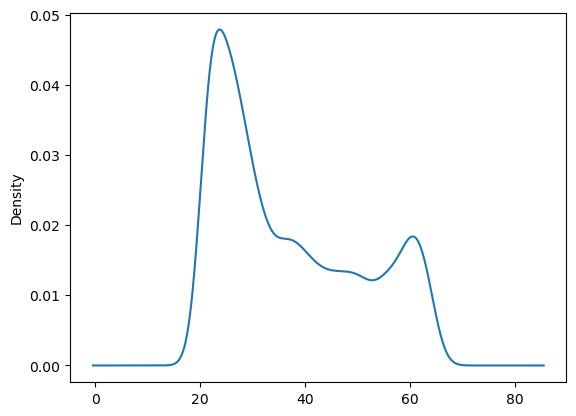

In [130]:
body_perform['age'].plot(kind = 'density')

In [129]:
X.describe()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,lean_BMI
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,0.367804,168.559807,67.447316,23.240165,78.823119,130.259671,36.972159,16.280739,40.145915,190.271695,18.058386
std,13.625639,0.482226,8.426583,11.949666,7.256844,10.664723,14.617382,10.610447,6.462138,13.744856,39.527763,2.371045
min,21.000000,0.000000,125.000000,26.300000,3.000000,41.000000,77.000000,1.600000,0.100000,1.000000,20.000000,5.101808
25%,25.000000,0.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,12.200000,31.000000,162.000000,16.114653
50%,32.000000,0.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.280739,41.000000,193.000000,18.250354
75%,48.000000,1.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000,19.851168
max,64.000000,1.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,42.000000,80.000000,303.000000,27.029721


In [184]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
pca = PCA(n_components=3)
scaler = StandardScaler()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [185]:
param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
              'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=3)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print(f"Best params: {best_params}")

svm_clf = SVC(**best_params)
svm_clf.fit(X_train, y_train)

print_score(svm_clf, X_train, y_train, X_test, y_test, train=True)
print_score(svm_clf, X_train, y_train, X_test, y_test, train=False)

Fitting 3 folds for each of 126 candidates, totalling 378 fits
Best params: {'C': 1, 'gamma': 0.75, 'kernel': 'rbf'}
Train Result:
Accuracy Score: 40.48%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1            2            3  accuracy  \
precision     0.403411     0.383032     0.339695     0.455520    0.4048   
recall        0.594970     0.257983     0.224276     0.552426    0.4048   
f1-score      0.480813     0.308310     0.270175     0.499315    0.4048   
support    2306.000000  2380.000000  2381.000000  2308.000000    0.4048   

             macro avg  weighted avg  
precision     0.395414      0.394884  
recall        0.407414      0.404800  
f1-score      0.389653      0.388079  
support    9375.000000   9375.000000  
_______________________________________________
Confusion Matrix: 
 [[1372  402  279  253]
 [ 832  614  393  541]
 [ 734  383  534  730]
 [ 463  204  366 1275]]

Test Result:
Accuracy Score: 40.57%
______

In [ ]:
# need feature selection, after selection, use pca again